In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install torch torchvision
#for local:
#pip install pycocotools

#for colab:
!pip install cython
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'


  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-1h48bb33
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-1h48bb33
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=264332 sha256=5c2945a560a14106fcac3ad1b078a976a5b2e853b81c2b137af30b17bb2daeed
  Stored in directory: /tmp/pip-ephem-wheel-cache-850yp0co/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.4
    Uninstalling pycocotools-2.0.4:
      Successfully uninstalled pycocotools-2.0.4


In [ ]:
# Clone TorchVision repo and copy helper files
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0
%cd ..
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 129440, done.
remote: Counting objects: 100% (538/538), done.
remote: Compressing objects: 100% (510/510), done.
remote: Total 129440 (delta 495), reused 48 (delta 26), pack-reused 128902
Receiving objects: 100% (129440/129440), 254.38 MiB | 28.79 MiB/s, done.
Resolving deltas: 100% (113407/113407), done.
/content/vision
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084d version check against PyTorch's CUDA version
/content


In [ ]:
!pip uninstall opencv-python-headless
!pip install opencv-python-headless==4.1.2.30

     |████████████████████████████████| 21.8 MB 152 kB/s 


In [ ]:
#for image augumentation:
!pip install opencv-python
!pip install -U albumentations

     |████████████████████████████████| 102 kB 14.2 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
# basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd

# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2
from torchvision.io import read_image
from PIL import Image

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# helper libraries
from engine import train_one_epoch, evaluate
import utils
import transforms as T


import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

import csv



%matplotlib inline

device = torch.device("cuda:0") # Let's make sure GPU is available!

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:

root = 'drive/MyDrive'
data_folder = os.path.join(root, "MSRM_x1 RGB Fixed Val Augmentation")



train_folder = os.path.join(data_folder, 'train')
test_folder = os.path.join(data_folder, 'test')
val_folder = os.path.join(data_folder, 'val')

train_data = os.path.join(train_folder, 'data')
train_labels = os.path.join(train_folder, 'classification.csv')

test_data = os.path.join(test_folder, 'data')
test_labels = os.path.join(test_folder, 'classification.csv')

val_data = os.path.join(val_folder, 'data')
val_labels = os.path.join(val_folder, 'classification.csv')

parts_data = os.path.join(data_folder, 'parts')

#print(os.path.join(test_data, os.listdir(train_data)[0]))

In [ ]:
import albumentations as A
import cv2

In [ ]:
width = 224
height = 224

In [ ]:
from google.colab.patches import cv2_imshow

class BMoundDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.bounding_boxes  = pd.read_csv(annotations_file)

        self.img_dir = img_dir
        self.images = [image for image in sorted(os.listdir(img_dir))]
        self.img_labels = pd.read_csv(annotations_file)

        self.transform = transform

    def generate_original_image_data(self):
      image_data = []
      for image in self.images:
        im = Image.open(os.path.join(test_data, image))
        width, height = im.size
        image_data.append((image, width, height))
      return image_data

    def __len__(self):
        return len(self.images)
    

    def __getitem__(self, index):
      img_name = self.images[index]
      img_path = os.path.join(self.img_dir, img_name)
      image = cv2.imread(img_path)

      records = self.img_labels.loc[self.img_labels.filename == img_name]
      bounding_boxes = []
      labels = []
      area = []

      for i in range(len(records)):
        record = records.iloc[i]
        labels.append('qanats')
        bounding_boxes.append([
          record.xmin,
          record.ymin,
          record.xmax,
          record.ymax,
        ])
        area.append((record.xmax - record.xmin) * (record.ymax - record.ymin))

      area = torch.as_tensor(area, dtype=torch.float32)

      
      if self.transform is not None:
        image_numpy = np.array(image)

        transformed = self.transform(
          image=image_numpy,
          bboxes=bounding_boxes,
          class_labels=labels
        )
        image = transformed['image']
        transformed_bounding_boxes = transformed['bboxes']
        
        if len(bounding_boxes) == 0:
          transformed_bounding_boxes = torch.zeros((0, 4), dtype=torch.float32)

      labels = torch.ones(len(records), dtype=torch.int64)
      
      tensor_bounding_boxes = torch.as_tensor(transformed_bounding_boxes, dtype=torch.float32)
      iscrowd = torch.zeros((tensor_bounding_boxes.shape[0],), dtype=torch.int64)

      target = {}
      target["boxes"] = tensor_bounding_boxes
      target["labels"] = labels
      target["image_id"] = torch.tensor([index])
      target["area"] = area
      target["iscrowd"] = iscrowd

      return image, target
      
# check dataset
dataset = BMoundDataset(train_labels, train_data)




In [ ]:
from albumentations.augmentations.transforms import HorizontalFlip
from albumentations.pytorch.transforms import ToTensorV2
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler



train_transform = A.Compose([
    A.Resize(width, height),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

test_transform = A.Compose([
     A.Resize(width, height),
     A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'])) 




train_dataset = BMoundDataset(train_labels, train_data, train_transform)
test_dataset = BMoundDataset(test_labels, test_data, test_transform)
val_dataset = BMoundDataset(val_labels, val_data, test_transform)

img, target = train_dataset[1]



In [ ]:
batch_size = 10

data_size = len(train_dataset)


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=4,
    collate_fn=utils.collate_fn
)


val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=4,
    collate_fn=utils.collate_fn
)


test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=4,
    collate_fn=utils.collate_fn
    )

In [ ]:
def get_object_detection_model(num_classes = 2):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
  return model

In [ ]:
# train on gpu if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2 # one class (class 0) is dedicated to the "background"

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 50 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(
  optimizer,
  step_size=50,
  gamma=0.1
)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
# the function takes the original prediction and the iou threshold.
def apply_nms(orig_prediction, iou_thresh=0.3):
  # torchvision returns the indices of the bboxes to keep
  keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
  final_prediction = orig_prediction
  final_prediction['boxes'] = final_prediction['boxes'][keep].cpu()
  final_prediction['scores'] = final_prediction['scores'][keep].cpu()
  final_prediction['labels'] = final_prediction['labels'][keep].cpu()
  
  return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
  return torchtrans.ToPILImage()(img).convert('RGB')

In [ ]:
class Stats:
    def __init__(self):
        self.tp = 0
        self.fp = 0
        self.fn = 0
        self.counter = 0

    def send(self, tp, fp, fn):
        self.tp += tp
        self.fp += fp
        self.fn += fn
        self.counter += 1

    def get_precision(self):
      if (self.tp + self.fp) == 0:
        return 0
      else:
        return self.tp / (self.tp + self.fp)

    def get_recall(self):
      if (self.tp + self.fn) == 0:
        return 0
      else: 
        return self.tp / (self.tp + self.fn)

    def get_true_positives(self):
      return self.tp

    def get_false_positives(self):
      return self.fp

    def get_false_negatives(self):
      return self.fn

    def get_counter(self):
      return self.counter

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, num_epochs):
  loss_history = []
  train_history = []
  val_history = []

  loss_hist = Averager()
  train_hist = Averager()
  val_hist = Averager()

  for epoch in range(num_epochs):
    model.train()

    loss_hist.reset()
    train_hist.reset()
    val_hist.reset()

    for images, targets in train_loader:
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
      loss_dict = model(images, targets)

      losses = sum(loss for loss in loss_dict.values())
      loss_value = losses.item()

      loss_hist.send(loss_value)

      optimizer.zero_grad()
      losses.backward()
      optimizer.step()
    
    evaluate(model, val_loader)
    print("Loss: ", loss_hist.value)  
    print("Epoch: ", epoch + 1)


#Precision measures how accurate is your predictions. i.e. the percentage of your predictions are correct.
#Recall measures how good you find all the positives. For example, we can find 80% of the possible positive cases in our top K predictions.

def evaluate(model, loader):
    model.eval() # Evaluation mode
    stats = Stats()
    with torch.no_grad():
        for images, targets in loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            results = model(images)
            for i, result in enumerate(results):
              nms_prediction = apply_nms(results[i], iou_thresh=0.1)
              ground_truth = targets[i]
              iou = torchvision.ops.box_iou(nms_prediction['boxes'].to(device), ground_truth['boxes'].to(device))
              predicted_boxes_count, gt_boxes_count = list(iou.size())

              if predicted_boxes_count == 0 and gt_boxes_count == 0:
                continue
              
              tp, fp, fn = compute_accuracy(iou)
              stats.send(tp, fp, fn)


    print("Precision: ", stats.get_precision())
    print("Recall: ", stats.get_recall())

            
            
def compute_accuracy(iou):
  predicted_boxes_count, gt_boxes_count = list(iou.size())
    
  fp = 0
  tp = 0

  for box in iou:
    valid_hits = [i for i, x in enumerate(box) if x > 0.5 ]
    if len(valid_hits) == 0:
      fp = fp + 1
      continue
    tp = tp + 1
    

  fn = gt_boxes_count - tp
  return tp, fp, fn



In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
#lr_scheduler = None

if torch.cuda.is_available():
    model.cuda()


train_model(model, train_loader, val_loader, optimizer, 200)

Precision:  0
Recall:  0.0
Loss:  0.3269849052735876
Epoch:  1
Precision:  0.0048500881834215165
Recall:  0.047619047619047616
Loss:  0.23662966382731987
Epoch:  2
Precision:  0.0049838026414154
Recall:  0.08658008658008658
Loss:  0.20865445859651474
Epoch:  3
Precision:  0.006640106241699867
Recall:  0.021645021645021644
Loss:  0.24027916422639226
Epoch:  4
Precision:  0.0
Recall:  0.0
Loss:  0.2121595462587483
Epoch:  5
Precision:  0.011099079588521927
Recall:  0.1774891774891775
Loss:  0.20771162668587867
Epoch:  6
Precision:  0.009230769230769232
Recall:  0.12987012987012986
Loss:  0.2438622217102776
Epoch:  7
Precision:  0.015469233413544173
Recall:  0.19480519480519481
Loss:  0.2141695003660773
Epoch:  8
Precision:  0.016535874439461883
Recall:  0.2554112554112554
Loss:  0.2355823188048342
Epoch:  9
Precision:  0.018619934282584884
Recall:  0.22077922077922077
Loss:  0.2504226548354263
Epoch:  10
Precision:  0.01806182702327197
Recall:  0.22510822510822512
Loss:  0.25599529000211

In [ ]:
def save_model(model, path):
  torch.save(model, path)

def load_model(path):
  model = torch.load(path)
  return model

model_file = os.path.join(data_folder, "model_200_no_optim_msrm_x1_best.pt")
torch.save(model, model_file)
#model = load_model(model_file)


In [ ]:
def write_results_summary_csv(num_test_images, true_positives, false_positives, false_negatives, learning_rate, num_epoch, result_filename):
    with open(os.path.join(root, result_filename + ".csv"), "w", newline='') as write_obj:
      csv_writer = csv.writer(write_obj)
      csv_writer.writerow([f"# of Test Images: {num_test_images} "])
      csv_writer.writerow([f"# of True Positives: {true_positives}"])
      csv_writer.writerow([f"# of False Positives: {false_positives}"])
      csv_writer.writerow([f"# of False Negatives: {false_negatives}"])
      csv_writer.writerow([f"Precision: {true_positives/(true_positives+false_positives)}"])
      csv_writer.writerow([f"Recall: {true_positives/(true_positives+false_negatives)}"])
      csv_writer.writerow("")
      csv_writer.writerow(["Model Settings:"])
      csv_writer.writerow([f"# of Epochs: {num_epoch}"])
      csv_writer.writerow([f"Learning Rate: {learning_rate}"])


def evaluate_model(model, loader):
    model.eval() # Evaluation mode
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    counter = 0
    for images, targets in loader:
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
      results = model(images)
      for i, result in enumerate(results):
        nms_prediction = apply_nms(results[i], iou_thresh=0.1)
        ground_truth = targets[i]
        iou = torchvision.ops.box_iou(nms_prediction['boxes'].to(device), ground_truth['boxes'].to(device))
        tp, fp, fn = compute_accuracy(iou)
        true_positives = true_positives + tp
        false_positives = false_positives + fp
        false_negatives = false_negatives + fn
        counter = counter + 1
    print("For total of ", counter, " images the results are following:")
    print("True positives: ", true_positives)
    print("False positives: ", false_positives)
    print("False negatives: ", false_negatives)
    print("Recall: ", true_positives / (true_positives + false_negatives))
    print("Precision: ", true_positives / (true_positives + false_positives))
    write_results_summary_csv(counter, true_positives, false_positives, false_negatives, 0.005, 200, "MSRM_x1_RGB_Fixed_Val_Add_Augm_200_Epochs_Summary_1")
    


evaluate_model(model, test_loader)

For total of  46  images the results are following:
True positives:  54
False positives:  54
False negatives:  25
Recall:  0.6835443037974683
Precision:  0.5


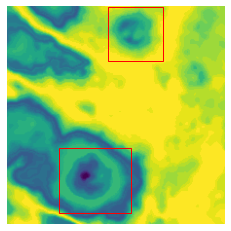

In [ ]:
def display_image(image, bboxes, gt_boxes=None):
    plt.imshow(image[0])
    ax = plt.gca()
    plt.grid(False)
    plt.axis('off')               

    for box in bboxes["boxes"]:
      x_min, y_min, x_max, y_max = box
      width = x_max - x_min
      height = y_max - y_min
      rect = patches.Rectangle((x_min, y_min), width, height, edgecolor='r', facecolor='none')
      ax.add_patch(rect)
    if gt_boxes != None:
      for box in gt_boxes["boxes"]:
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min
        rect = patches.Rectangle((x_min, y_min), width, height, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
      

Manual testing:

{'boxes': tensor([[103.0400,  20.1600, 181.4400,  76.1600]]), 'labels': tensor([1]), 'image_id': tensor([1]), 'area': tensor([3500.]), 'iscrowd': tensor([0])}


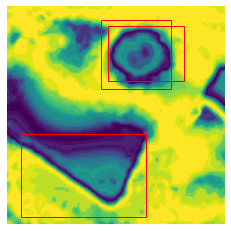

In [ ]:
# pick one image from the test set
img, target = test_dataset[1]
print(target)
model.eval()
with torch.no_grad():
  prediction = model([img.to(device)])[0]
    
#print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.1)
display_image(img, nms_prediction, target)
display_image(img, target)

In [ ]:

#Scan of large MSRM_x1 image of test area. Set overlap to 0.5 to use overlap scan with 50% percent overlap.
from torchvision.transforms.transforms import Resize
split_width = 400
split_height = 400
image_height = 400
image_width = 400
overlap = 0


transform = A.Compose([
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    ToTensorV2()
])


def resize_bboxes(prediction):
  result = []
  for box in prediction:
    x_min, y_min, x_max, y_max = box
    x1p = x_min / split_width;
    x2p = x_max / split_width;
    y1p = y_min / split_height;
    y2p = y_max / split_height;
    result.append([
      x1p * image_width,
      y1p * image_height,
      x2p * image_width,
      y2p * image_height
    ])

  return result

def start_points(size, split_size):
  points = [0]
  stride = int(split_size * (1 - overlap))
  counter = 1
  while True:
    pt = stride * counter
    if pt + split_size >= size:
      points.append(size - split_size)
      break
    else:
      points.append(pt)
      counter += 1
  return points


def display_image(image, bboxes, n):
    plt.imshow(image[0])
    ax = plt.gca()
    plt.subplot(2, 2, n)
    plt.grid(False)
    plt.axis('off')               
    plt.rcParams["figure.figsize"] = (1,1)

    for box in bboxes["boxes"]:
      x_min, y_min, x_max, y_max = box
      width = x_max - x_min
      height = y_max - y_min
      rect = patches.Rectangle((x_min, y_min), width, height, edgecolor='r', facecolor='none')
      ax.add_patch(rect)

      

def split_image(image):
  img_height, img_width, _ = img.shape
  X_points = start_points(img_width, split_width)
  Y_points = start_points(img_height, split_height)
  
  images = np.empty(shape=(len(X_points), len(Y_points)))
  images = [[[] for i in range(len(X_points))] for i in range(len(Y_points))]
  count = 0

  for i, y_point in enumerate(Y_points):
    for j, x_point in enumerate(X_points):
      split = img[y_point:y_point + split_height, x_point:x_point + split_width]
      images[i][j] = split
      
      #storing

      image_path = os.path.join(
        data_folder,
        "parts",
        'splitted_{}_{}'.format(i, j),
        '.png'
      )
      cv2.imwrite(image_path, split)
      count += 1
  return np.array(images)
             



def get_bounding_boxes(images):
  model.eval()
  bboxes = [[[] for i in range(images.shape[0])] for i in range(images.shape[1])]
  low_scores_count = 0
  for j, row in enumerate(images):
    for i, image in enumerate(row):
      image_numpy = np.array(image)
      transformed_image = transform(image=image_numpy)['image']
      with torch.no_grad():
        prediction = model([transformed_image.to(device)])[0]
        nms_prediction = apply_nms(prediction, iou_thresh=0.1)
        bboxes[i][j] = nms_prediction['boxes']
        for box in nms_prediction['boxes']:
          x_min, y_min, x_max, y_max = box
          cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        image_path = os.path.join(test_folder, 'predictions', '{}_{}.png'.format(i, j))
        cv2.imwrite(image_path, image)
  return bboxes


def normalize_coordinates(bboxes):
  normalized_boxes = []
  #resized_boxes = resize_bboxes(bboxes)
  for x, row in enumerate(bboxes):
    for y, boxes in enumerate(row):
      x_overlap_padding = overlap * x * split_width
      y_overlap_padding = overlap * y * split_height
      x_padding, y_padding = x * split_width, y * split_height
      for i, box in enumerate(boxes):
        x_min, y_min, x_max, y_max = box
        normalized_boxes.append([
          x_min + x_padding - x_overlap_padding,
          y_min + y_padding - y_overlap_padding,
          x_max + x_padding - x_overlap_padding,
          y_max + y_padding - y_overlap_padding,
          "{}_{}".format(x, y)                              
        ])
  return normalized_boxes

#Saves png image with result bounding boxes.
def save_image(image, bboxes):
  for box in bboxes:
    x_min, y_min, x_max, y_max, label = box
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

  image_path = os.path.join(data_folder, 'Composite_MSRM_x1_Results_without_Overlap_400.png') 
  cv2.imwrite(image_path, image)

def count_boxes(predictions):
  count = 0
  for y, row in enumerate(predictions):
    for x, boxes in enumerate(row):
      count = count + len(boxes))
  print("count_boxes: ", count)

def generate_result_csv(csv_name, bboxes):  
  headers = ['xmin', 'ymin', 'xmax', 'ymax']
  with open(csv_name, 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(headers)
  
    for box in bboxes:
        xmin, ymin, xmax, ymax, label = box
        writer.writerow([
          xmin.item(), ymin.item(), xmax.item(), ymax.item(),
        ])

def save_parts_with_bb(images, boxes):
  print(images[0][0])
  for y, row in enumerate(bboxes):
    for x, boxes in enumerate(row):
      pass

def analyze_image(image):
  dir = os.path.join(data_folder, "parts")
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))
  
  dir = os.path.join(test_folder, "predictions")
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

  images = split_image(image)
  bboxes = get_bounding_boxes(images)
  normalized_bboxes = normalize_coordinates(bboxes)
  save_image(image, normalized_bboxes)
  #Output csv file with results from scan
  generate_result_csv(os.path.join(data_folder, 'Composite_MSRM_x1_Results_without_Overlap_600.csv'), normalized_bboxes)
  

image_name = "Rogaland_2016_Composite_MSRM_x1.png"
image_path = os.path.join(root, image_name)
img = cv2.imread(image_path)

analyze_image(img)